# SAT Optics Simulation: Far-Field

This notebook models the far-field beam of the Small Aperture Telescope.  We use the near-field beam simulated in the $\verb|sat_holography|$ notebook and the fourier relationship between near- and far-fields to propagate this beam into the far-field. 

Grace E. Chesmore
March 2022

### Read in the near-field beam


In [14]:
import numpy as np
import matplotlib
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from scipy import interpolate

%matplotlib inline

import sosat_optics
from sosat_optics import ot_geo, opt_analyze,ray_trace

# Load in telescope geometry
tele_geo = ot_geo.SatGeo()
tele_geo.n_scan = 50  # sample number in 1D of 2D grid
tele_geo.y_source = (
    ot_geo.y_lyot + 100
)  # distance of holography source from SAT focal plane.
tele_geo.lambda_ = 0.002  # wavelength of source, here we choose 150GHz.
tele_geo.k = 2 * np.pi / tele_geo.lambda_  # update kappa

rx = [0,0,100]  # receiver feed position in focal plane [mm]
x_sim, y_sim, a_sim, p_sim = ray_trace.rx_to_lyot(rx, tele_geo, 0, "b")
# Convert pathlength to phase
p_sim = np.mod(tele_geo.k * (p_sim - np.mean(p_sim)) / 1e3 / 2, 2 * np.pi)

In [15]:
# Define the complex beam from ray-trace outputs
noise = 1e-6  # signal-to-noise of holography setup
a_sim /= np.max(abs(a_sim))
a_sim = a_sim + noise
beam_sim = (a_sim / np.max(a_sim)) * np.exp(complex(0, 1) * p_sim)

# Define the dimmensions of the waveguide
apert1 = 1  # [cm]
apert2 = 1  # [cm]

# Convolve beam
x, y, beam_conv = opt_analyze.beam_convolve(
    np.real(x_sim) / 1e1, np.real(y_sim) / 1e1, beam_sim, apert1, apert2, 0
)

## Propagating Aperture-field into the Far-field

Now that we have our near-fields $b(x,y)$ above the SAT window, we want to propagate the fields into the far-field $B(\theta,\phi)$ using the relation:

$$ B(\theta,\phi) = \int_{aperture} b(x,y)e^{i2\pi(x\theta + y\phi)} dx dy$$

where we integrate over the aperture, which is the window of the SAT.

In [16]:
# Zero padding: to increase the resolution of our far-field
# we zero-pad the aperture fields before propagating.  Set
# the number of pixels to pad to the array.
pix_num = 20

x_new, y_new, beam_final = opt_analyze.zero_pad(x, y, beam_conv, pix_num)

# plt.figure(figsize=(6, 5))
# plt.pcolormesh(x_new, y_new, np.abs(beam_final)/np.max(np.abs(beam_final)))
# plt.colorbar()
# plt.xlabel("x [cm]")
# plt.ylabel("y [cm]")
# plt.title("Near-field of SAT")
# plt.axis("equal")
# plt.show()

# plt.figure(figsize=(6, 5))
# plt.pcolormesh(x_new, y_new, np.arctan2(np.imag(beam_final), np.real(beam_final)))
# plt.colorbar()
# plt.xlabel("x [cm]")
# plt.ylabel("y [cm]")
# plt.title("Near-field of SAT")
# plt.axis("equal")
# plt.show()


<ipython-input-17-3200d7edca88>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_data, y_data, np.abs(beam_data)/np.max(np.abs(beam_data)))


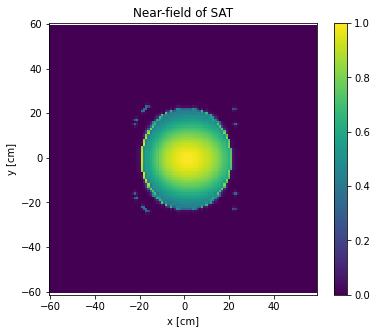

<ipython-input-17-3200d7edca88>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_data, y_data, phase_data)


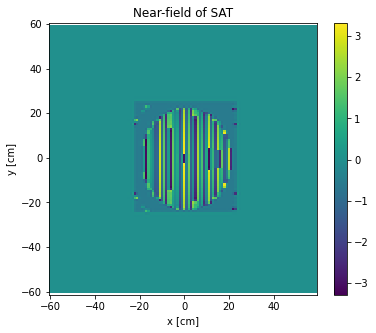

In [17]:

STAGE_RANGE = 121.0 # [cm]
STEP = 2.0/2 # [cm]
# Interpolate to new 2D grid    
x_interp = x_new[0, :]
y_interp = y_new[:, 0]
func_beam = interpolate.interp2d(x_interp, y_interp, np.abs(beam_final)/np.max(np.abs(beam_final)), kind='cubic')
func_phase = interpolate.interp2d(x_interp, y_interp, np.arctan2(np.imag(beam_final), np.real(beam_final)), kind='cubic')
x_data = np.arange(-STAGE_RANGE/2, STAGE_RANGE/2, STEP)
y_data = np.arange(-STAGE_RANGE/2, STAGE_RANGE/2, STEP)
beam_data = func_beam(x_data, y_data)
phase_data = func_phase(x_data, y_data)

x_data,y_data = np.meshgrid(x_data,y_data)
plt.figure(figsize=(6, 5))
plt.pcolormesh(x_data, y_data, np.abs(beam_data)/np.max(np.abs(beam_data)))
plt.colorbar()
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.title("Near-field of SAT")
plt.axis("equal")
plt.show()

plt.figure(figsize=(6, 5))
plt.pcolormesh(x_data, y_data, phase_data)
plt.colorbar()
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.title("Near-field of SAT")
plt.axis("equal")
plt.show()


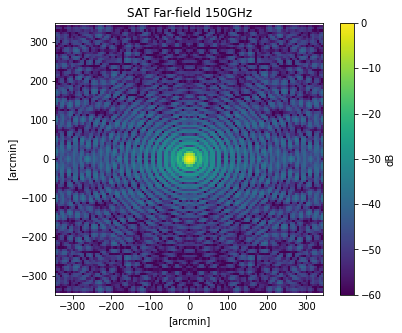

In [18]:
phase = np.arctan2(np.imag(beam_data), np.real(beam_data))
beam_fft, phase_fft = opt_analyze.a2b(beam_data, phase * 180 / np.pi)

x_ang, y_ang = opt_analyze.coords_spat_to_ang(
    x_data / 1e2, y_data / 1e2, opt_analyze.m_to_ghz(tele_geo.lambda_)
)

plt.figure(figsize=(6, 5))
plt.title("SAT Far-field 150GHz")
plt.pcolormesh(
    x_ang * 180 * 60 / np.pi,
    y_ang * 180 * 60 / np.pi,
    20 * np.log10(abs(beam_fft) / np.max(abs(beam_fft))),
    vmin=-60,
    shading="auto",
)
plt.xlabel("[arcmin]")
plt.ylabel("[arcmin]")
plt.colorbar(label="dB")
plt.axis("equal")
# plt.xlim(-80, 80)
# plt.ylim(-80, 80)
plt.show()

In [6]:
abs(x_ang[0,0] -  x_ang[0,1])*180*60/np.pi

11.271300887819478

## Predicted Beam Size
Our simulated beam size determines the resolution of our telescope.  We can compare this to the beam size of an Airy disc with aperture $D$ at wavelength $\lambda$:

$$\theta_{FWHM} = 1.025 \frac{\lambda}{D} $$

In [25]:
a = abs(beam_fft) ** 2 / np.max(abs(beam_fft) ** 2)
x_out = y_ang
y_out = x_ang

indx = np.where(abs(a) == np.max(abs(a)))
x = y_out[indx[0][0], :] * 60 * 180 / np.pi
y = abs(a)[indx[0][0], :] / np.max(abs(a))
v1 = x[np.where((y > 0.5))][0]
v2 = x[np.where((y > 0.5))][-1]

fwhm1 = abs(v1 - v2)

indx = np.where(abs(a) == np.max(abs(a)))
x = x_out[:, indx[1][0]] * 60 * 180 / np.pi
y = abs(a)[:, indx[1][0]] / np.max(abs(a))
v1 = x[np.where((y > 0.5))][0]
v2 = x[np.where((y > 0.5))][-1]

fwhm2 = abs(v1 - v2)
fwhm = (fwhm1 + fwhm2) / 2
print(f"Simulated beam size: {fwhm:.2f} arcmin.")
print(
    f"Predicted beam size: {opt_analyze.rad_to_arcmin((1.025*tele_geo.lambda_ /tele_geo.diam)):.2f} arcmin."
)

Simulated beam size: 11.00 arcmin.
Predicted beam size: 16.78 arcmin.
